In [1]:
import torch
import numpy as np
import cv2
import os 
import pandas as pd
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch.functional import img_to_tensor
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

In [2]:
from helpers.config import load_config
from helpers.utils import create_optimizer, AverageMeter
from helpers.losses import miou_round, val_miou_round
from helpers import losses
conf = load_config('helpers/effb7_conf.json') 

In [3]:
#helpers5classes
#helpers

In [4]:
PTH = 'Oil Spill Detection Dataset/'

In [5]:
train = os.path.join(PTH, 'train/images')
train_mask = os.path.join(PTH, 'train/labels')

valid = os.path.join(PTH, 'test/images')
valid_mask = os.path.join(PTH, 'test/labels')

# Create transforms

In [6]:
def create_train_transforms():
    #(650,1250) > 512x512 > 512x512 > (650x1250) > 
    
    return A.Compose([
        A.RandomCrop(640, 640, p=1.0),
        A.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=15, p=0.5),
        A.OneOf([
            A.MotionBlur(p=.33),
            A.MedianBlur(blur_limit=3, p=.33),
            A.Blur(blur_limit=3, p=.33),
        ], p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=0.5)
    ])

def create_val_transforms():
    return A.Compose([
        A.Crop(0,0,640,640, p=1.0)
    ])

In [7]:
imagee = cv2.imread("Preprocessing Folder/png_files/0012.png")

In [8]:
imagee = cv2.cvtColor(imagee, cv2.COLOR_BGR2RGB)

In [9]:
transformer = create_train_transforms()

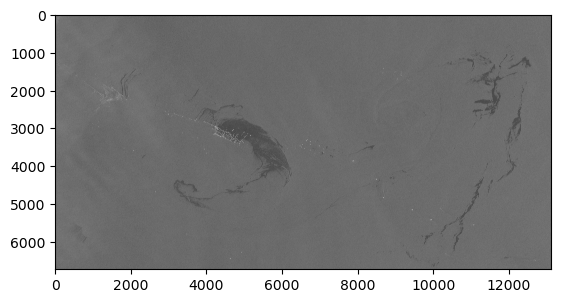

In [10]:
plt.imshow(imagee) # No augmentation

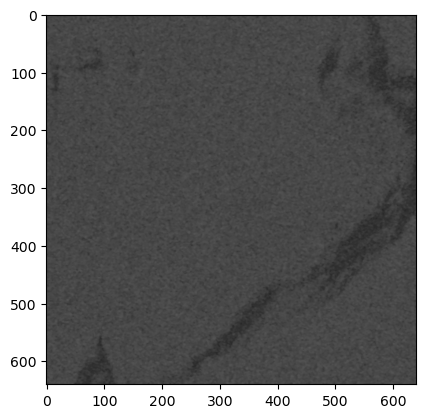

In [11]:
plt.imshow(transformer(image=imagee)['image']) # Augmentation

# Convert RGB mask to 1D mask

In [12]:
def rgb_to_label(rgb_mask):
    color_to_label = {
        (0,0,0): 0,
        (0,255,255): 1,
        (255,0,0): 2,
        (153, 76,0): 3,
        (0,153,0): 4
    }
    height, width, _ = rgb_mask.shape
    label_mask = np.zeros((height, width), dtype = np.uint8)
    
    for color, label in color_to_label.items():
        indices = np.where(np.all(rgb_mask==color, axis=-1))
        #print(indices)
        label_mask[indices] = label
    return label_mask

In [13]:
rgb_mask = cv2.imread('Oil Spill Detection Dataset/train/labels/42_916,10_638_3.png')

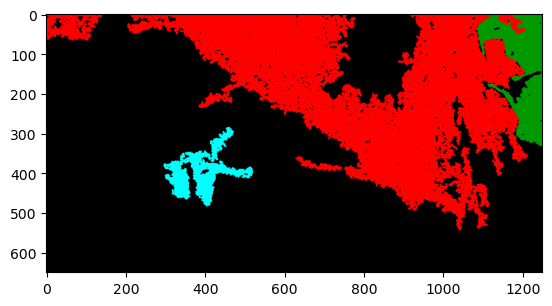

In [14]:
plt.imshow(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [15]:
label_mask = rgb_to_label(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [16]:
label_mask[label_mask!=1] = 0

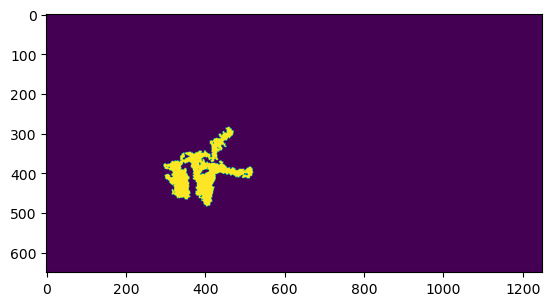

In [17]:
plt.imshow(label_mask)

In [18]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

# Create CSV with common file names

In [19]:
def common_ims(img_pth, mask_pth, mode):
    img_ids = os.listdir(img_pth)
    mask_ids = os.listdir(mask_pth)
    mask_ids = [s.replace('png', 'jpg') for s in mask_ids]
    
    img_df = pd.DataFrame({'filename': img_ids})
    mask_df = pd.DataFrame({'filename': mask_ids})

    merged_df = pd.merge(img_df, mask_df, on='filename')
    merged_df.to_csv(f'{mode}.csv', index=False)

In [20]:
common_ims(train, train_mask, 'train')
common_ims(valid, valid_mask, 'valid')

In [21]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('valid.csv')

In [22]:
len(os.listdir(train)), len(os.listdir(train_mask))

(1002, 1002)

# Dataset

In [23]:
class OilDataset(Dataset):
    def __init__(self, df, mode='train', classes=None, augmentations = None, normalize = None):
        self.df = df['filename']
        self.mode = mode
        self.classes = classes
        self.augmentations = augmentations
        self.normalize = normalize
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(f'Oil Spill Detection Dataset/{self.mode}/images/', self.df[idx]))
        mask = cv2.imread(os.path.join(f'Oil Spill Detection Dataset/{self.mode}/labels/', self.df[idx].replace('jpg', 'png')))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = rgb_to_label(mask) # (0,255,255) > 1, .... -> 0, ... -> 2
        
        mask[mask!=1] = 0
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            #image, mask = sample['image'], sample['mask']
        
        mask = np.zeros((self.classes, *sample["mask"].shape[:2]))
        for i in range(self.classes):
            mask[i, sample["mask"] == i] = 1
        
        sample['img_name'] = os.path.join(f'Oil Spill Detection Dataset/{self.mode}/images/', self.df[idx])
        sample['mask_orig'] = sample['mask']
        sample['mask'] = torch.from_numpy(np.ascontiguousarray(mask)).float()
        sample['image'] = img_to_tensor(np.ascontiguousarray(sample['image']), self.normalize)
        return sample
        
        

In [24]:
dataset = OilDataset(train_df, mode='train', classes = 2, augmentations=create_train_transforms(), normalize = conf['input']['normalize'])

In [25]:
dataset[0]['image'].shape, dataset[0]['img_name'], dataset[0]['mask'].shape, dataset[0]['mask_orig'].shape


(torch.Size([3, 640, 640]),
 'Oil Spill Detection Dataset/train/images/27_884,-17_39_2.jpg',
 torch.Size([2, 640, 640]),
 (640, 640))

# Config

# Train

In [26]:
def train_epoch(current_epoch, loss_functions, model, optimizer, scheduler, train_data_loader, 
                summary_writer, conf):
    losses = AverageMeter()
    mious = AverageMeter()
    iterator = tqdm(train_data_loader)
    model.train()
    if conf["optimizer"]["schedule"]["mode"] == "epoch":
        scheduler.step(current_epoch)
    for i, sample in enumerate(iterator):
        imgs = sample["image"].cuda()
        masks = sample["mask"].cuda().float()
        masks_orig = sample["mask_orig"].cuda().float()
        out_mask = model(imgs)
        with torch.no_grad():
            pred = torch.softmax(out_mask, dim=1)
            argmax = torch.argmax(pred, dim=1)
            ious = miou_round(argmax, masks_orig).item()

        mious.update(ious, imgs.size(0))

        mask_loss = loss_functions["mask_loss"](out_mask, masks.contiguous())
        loss = mask_loss
        losses.update(loss.item(), imgs.size(0))
        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss ({loss.avg:.4f}); miou ({miou.avg:.4f}); ".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, miou=mious))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        #torch.cuda.synchronize()

        if conf["optimizer"]["schedule"]["mode"] in ("step", "poly"):
            scheduler.step(i + current_epoch * len(train_data_loader))
   
    for idx, param_group in enumerate(optimizer.param_groups):
        lr = param_group['lr']
        summary_writer.add_scalar('group{}/lr'.format(idx), float(lr), global_step=current_epoch)
    summary_writer.add_scalar('train/loss', float(losses.avg), global_step=current_epoch)

In [27]:
def validate(net, data_loader, predictions_dir):
    os.makedirs(predictions_dir, exist_ok=True)
    preds_dir = predictions_dir + "/predictions"
    os.makedirs(preds_dir, exist_ok=True)
    mious = []
    oil_class_iou = []
    with torch.no_grad():
        for sample in tqdm(data_loader):
            imgs = sample["image"].cuda().float()
            mask_orig = sample["mask_orig"].cuda().float()

            output = net(imgs)
            pred = torch.softmax(output, dim=1)
            argmax = torch.argmax(pred, dim=1)

            for i in range(output.shape[0]):
                d, ious = val_miou_round(argmax, mask_orig)
                
                mious.append(d.item())
                oil_class_iou.append(ious[1].item())
                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_prediction.png"),
                            argmax[i].cpu().numpy().astype(np.uint8) * 64)

                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_mask_orig.png"),
                            mask_orig[i].cpu().numpy().astype(np.uint8) * 64)
    print(np.mean(oil_class_iou))
    return np.mean(mious)
def evaluate_val(output_dir, data_val, miou_best, model, snapshot_name, current_epoch, optimizer, summary_writer,
                 predictions_dir):
    print("Test phase")
    model = model.eval()
    miou = validate(model, data_loader=data_val, predictions_dir=predictions_dir)
    summary_writer.add_scalar('val/miou', float(miou), global_step=current_epoch)
    if miou > miou_best:
        if output_dir is not None:
            torch.save({
                'epoch': current_epoch + 1,
                'state_dict': model.state_dict(),
                'miou_best': miou,

            }, output_dir +'/' + snapshot_name + "_best_miou.pt")
        miou_best = miou
    torch.save({
        'epoch': current_epoch + 1,
        'state_dict': model.state_dict(),
        'miou_best': miou_best,
    }, output_dir + '/'+ snapshot_name + "_last.pt")
    print("miou: {}, miou_best: {}".format(miou, miou_best))
    return miou_best

In [28]:
import segmentation_models_pytorch as smp



# 1st method

In [29]:
model = smp.Unet(encoder_name='efficientnet-b7', classes=2) # effnet on ImageNet 1000 classes

# 2nd method

In [30]:
# model = smp.Unet(encoder_name='efficientnet-b7', classes=5, encoder_weights=None) # effnet on ImageNet 1000 classes
# checkpoint = torch.load('models/5 classes/Efficientnet-b7 74% Val Acc/segment_efficientnet-b7_efficientnet-b7_best_miou.pt', map_location='cpu') # 5 class Segmentation model on greece dataset
# state_dict = checkpoint['state_dict']
# model.load_state_dict(state_dict, strict=False)
# model.segmentation_head[0] = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [31]:
model = model.cuda()

In [32]:
mask_loss_function = losses.__dict__[conf["mask_loss"]["type"]](**conf["mask_loss"]["params"]).cuda()
loss_functions = {"mask_loss": mask_loss_function}
optimizer, scheduler = create_optimizer(conf['optimizer'], model)

miou_best = 0
start_epoch = 0
batch_size = conf['optimizer']['batch_size']
#print(train_lst)
data_train = OilDataset(train_df,
                        mode='train', 
                        classes = 2, 
                        augmentations=create_train_transforms(), 
                        normalize = conf['input']['normalize'])
data_val = OilDataset(test_df,
                        mode='test', 
                        classes = 2, 
                        augmentations=create_val_transforms(), 
                        normalize = conf['input']['normalize'])
train_sampler = None

In [33]:
train_data_loader = DataLoader(data_train, batch_size=batch_size, 
                                   shuffle=train_sampler is None, sampler=train_sampler, pin_memory=False,
                                   drop_last=True) #num_workers=8,
#print(data_train.__getitem__(1)['image'].shape)
#print(data_train.__getitem__(1)['mask'].shape)
val_batch_size = 1
val_data_loader = DataLoader(data_val, batch_size=val_batch_size,  shuffle=False,
                             pin_memory=False) #num_workers=8,

In [34]:
#!mkdir predictions

In [35]:
output_dir = 'outputs'
predictions_path = 'predictions'

In [36]:
logdir = 'logs'
summary_writer = SummaryWriter(logdir + '/' + 'segment_' + conf['encoder'])

In [37]:
start_epoch = 0
current_epoch=0

In [38]:
snapshot_name = "{}{}_{}".format('segment_', conf['network'], conf['encoder'])

In [39]:
for epoch in range(start_epoch, conf['optimizer']['schedule']['epochs']):
        if train_sampler:
            train_sampler.set_epoch(epoch)

        model_encoder_stages = model.encoder
        model_encoder_stages.train()
        for p in model_encoder_stages.parameters():
            p.requires_grad = True
        train_epoch(current_epoch, loss_functions, model, 
                    optimizer, scheduler, train_data_loader, summary_writer, conf)

        model = model.eval()
        
        torch.save({
            'epoch': current_epoch + 1,
            'state_dict': model.state_dict(),
            'miou_best': miou_best,
        }, output_dir + '/' + snapshot_name + "_last")
        preds_dir = os.path.join(predictions_path, snapshot_name)
        miou_best = evaluate_val(output_dir, val_data_loader, miou_best, model,
                                 snapshot_name=snapshot_name,
                                 current_epoch=current_epoch,
                                 optimizer=optimizer, summary_writer=summary_writer,
                                 predictions_dir=preds_dir)
        current_epoch += 1


  0%|          | 0/501 [00:00<?, ?it/s]

C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable t

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5109328600768344
miou: 0.7499578091231259, miou_best: 0.7499578091231259


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.45191975053707345
miou: 0.7211237305944617, miou_best: 0.7499578091231259


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5288891071759263
miou: 0.759509816494855, miou_best: 0.759509816494855


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5895208708623754
miou: 0.7898483566262505, miou_best: 0.7898483566262505


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5882382159983125
miou: 0.7894511111757972, miou_best: 0.7898483566262505


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6390546780050194
miou: 0.8156249669465152, miou_best: 0.8156249669465152


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6221739474415565
miou: 0.8069511326876554, miou_best: 0.8156249669465152


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6347507075876613
miou: 0.8131288173523816, miou_best: 0.8156249669465152


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6448343910116959
miou: 0.8183135677467693, miou_best: 0.8183135677467693


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5873285868751215
miou: 0.7898771727626974, miou_best: 0.8183135677467693


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6337797380373428
miou: 0.8129138225858862, miou_best: 0.8183135677467693


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6524407720006338
miou: 0.8223494979468259, miou_best: 0.8223494979468259


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6392628705341552
miou: 0.8155342587015846, miou_best: 0.8223494979468259


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6479174838005514
miou: 0.8202093582261692, miou_best: 0.8223494979468259


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.645986748534833
miou: 0.819574284824458, miou_best: 0.8223494979468259


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6684871728076051
miou: 0.830387523228472, miou_best: 0.830387523228472


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6827407676500331
miou: 0.8378527283668518, miou_best: 0.8378527283668518


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6726383277348361
miou: 0.8328050521287051, miou_best: 0.8378527283668518


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6881782781002083
miou: 0.8405494367534464, miou_best: 0.8405494367534464


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7092944627204212
miou: 0.8513435054909099, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.684254701675315
miou: 0.8385928750038147, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6910777027417356
miou: 0.841797103936022, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6917651066979315
miou: 0.8426650594581258, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6847966228876441
miou: 0.8386459862644022, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6896405377772521
miou: 0.8414636080915278, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6893779740115736
miou: 0.841119139844721, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6947889115003983
miou: 0.8438727888193998, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7052471405171107
miou: 0.8488579500805248, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7008383459190709
miou: 0.8469014105471697, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7015517543378099
miou: 0.8473874395543879, miou_best: 0.8513435054909099


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7108175509366592
miou: 0.85197334587574, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.676734658013471
miou: 0.8343625271862204, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6956548718124135
miou: 0.8442777487364682, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7055255253071079
miou: 0.8492846857417714, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7040705749274331
miou: 0.8485570070418444, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6967498175478498
miou: 0.8448872089385986, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6676474461751861
miou: 0.8299691267988899, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6883061898763334
miou: 0.8405257596211, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.691681018945903
miou: 0.8424574667757208, miou_best: 0.85197334587574


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7119361434731241
miou: 0.8526731485670264, miou_best: 0.8526731485670264


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7072175690651469
miou: 0.850317284193906, miou_best: 0.8526731485670264


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7022933691823149
miou: 0.8479679310863668, miou_best: 0.8526731485670264


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6998117063512441
miou: 0.8466400533914566, miou_best: 0.8526731485670264


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6896760482786761
miou: 0.8414171573790636, miou_best: 0.8526731485670264


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7182201237045572
miou: 0.855890077623454, miou_best: 0.855890077623454


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6971898750746456
miou: 0.845227267796343, miou_best: 0.855890077623454


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7160436526204538
miou: 0.8547577906738628, miou_best: 0.855890077623454


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6886033176501453
miou: 0.840855964476412, miou_best: 0.855890077623454


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7025701682441933
miou: 0.8478849530220032, miou_best: 0.855890077623454


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7241031564788962
miou: 0.8588425240733407, miou_best: 0.8588425240733407


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7006965177724418
miou: 0.8469306915998459, miou_best: 0.8588425240733407


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7216490910120826
miou: 0.8577219128608704, miou_best: 0.8588425240733407


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7056166470898599
miou: 0.8495666444301605, miou_best: 0.8588425240733407


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7299969811024468
miou: 0.8619490655985745, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7166781824945293
miou: 0.8552809308875691, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7095283652942599
miou: 0.851583158698949, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7130203336304912
miou: 0.8533577726645903, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7056394105542456
miou: 0.8496093048290773, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6985588860370797
miou: 0.8459565674716776, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7172531588497794
miou: 0.8553973390297456, miou_best: 0.8619490655985745


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7449317391814847
miou: 0.8694561925801364, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7210882778175145
miou: 0.8573731514540586, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7141899130298465
miou: 0.8539940855719826, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7330498837194335
miou: 0.8635846319523725, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7032174829067256
miou: 0.84833349395882, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7017435010394967
miou: 0.8476725700226697, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7254828539916247
miou: 0.8597522543235259, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7093973360244711
miou: 0.8516369911757382, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7190202794437216
miou: 0.8563875902782787, miou_best: 0.8694561925801364


  0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
#w_new = w_old - 0.0003*(dE/dw_old)  oil_spill pretrained model 0.01 > 0.00001

# 1d to RGB

In [ ]:
import numpy as np
import cv2

def convert_mask(mask):
   
    color_mappings = {
        0: (0, 0, 0),
        1: (0, 255, 255),
        2: (255, 0, 0),
        3: (153, 76, 0),
        4: (0, 153, 0)
    }

   
    height, width= mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

   
    for class_idx, color in color_mappings.items():
        class_mask = (mask == class_idx)
        rgb_mask[class_mask] = color

    
    return rgb_mask


In [ ]:
img1 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_mask_orig.png')
img2 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_prediction.png')

In [ ]:
img1 = img1/64
img2 = img2/64

In [ ]:
plt.imshow(img1)

In [ ]:
plt.imshow(img2)

In [ ]:
plt.imshow(convert_mask(img1[:,:,1]))

In [ ]:
plt.imshow(convert_mask(img2[:,:,1]))

In [ ]:
img[:,:,1].shape

In [ ]:
# 650x1250 > 